In [22]:
import configparser
from pathlib import Path

config = configparser.ConfigParser()
config.read('../../../data/config/config.cfg')

phenopackets_out_dir = ('..' / Path(config.get('Paths', 'phenopackets_out'))).resolve()

phenopackets_out_dir

WindowsPath('C:/Users/Surface/OneDrive/Documents/DataSpell/ERKER2Phenopackets/ERKER2Phenopackets/data/out/phenopackets')

# read in data from phenopackets

In [23]:
from ERKER2Phenopackets.src.utils.io import read_files

example_phenopackets_dir = phenopackets_out_dir / 'example-phenopackets-from-synthetic-data'
pps = read_files(example_phenopackets_dir)

# convert phenopackets to dataframe
Necessary fields:
- id
- zygosity
- cHGVS mutation
- Obsesity Class and timestamp

In [24]:
print(pps[0])

id: "0"
subject {
  id: "0"
  date_of_birth {
    seconds: 946684800
  }
  sex: FEMALE
  taxonomy {
    id: "NCBITaxon:9606"
    label: "Homo sapiens"
  }
}
phenotypic_features {
  type {
    id: "HP:0001513"
    label: "Obesity"
  }
  excluded: true
  onset {
    timestamp {
      seconds: 708652800
    }
  }
}
interpretations {
  id: "e0dd47b3-6e13-4507-84a7-5606bee17024"
  progress_status: SOLVED
  diagnosis {
    disease {
      id: "ORPHA:71529"
      label: "Obesity due to melanocortin 4 receptor deficiency"
    }
    genomic_interpretations {
      subject_or_biosample_id: "0"
      interpretation_status: CONTRIBUTORY
      variant_interpretation {
        variation_descriptor {
          id: "id:A"
          expressions {
            syntax: "hgvs"
            value: "NP_005903.2:p.(Val103Ile)"
          }
          expressions {
            syntax: "hgvs"
            value: "NM_005912.3:c.181G>T"
          }
          allelic_state {
            id: "GENO:0000135"
            

In [25]:
from typing import Tuple, Any
from phenopackets import Phenopacket

sex_map = {0: 'unknown', 1: 'female', 2: 'male', 3: 'other'}

def extract_phenotype(phenotypic_features, i) -> Tuple[str, str, bool, int]:
    phenotypic_features = phenotypic_features[i]
    obesity_class_hpo = phenotypic_features.type.id
    obesity_class = phenotypic_features.type.label
    excluded = phenotypic_features.excluded
    onset = phenotypic_features.onset.timestamp.ToSeconds()
    return obesity_class_hpo, obesity_class, excluded, onset

def extract_fields(phenopacket: Phenopacket) -> tuple[
                                                    Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any] | None:
    pp_id = int(phenopacket.id)
    dob = phenopacket.subject.date_of_birth.ToSeconds()
    sex = sex_map[phenopacket.subject.sex]
    
    try:
        variation_descriptor = phenopacket.interpretations[0].diagnosis.genomic_interpretations[0].variant_interpretation.variation_descriptor
        
        c_hgvs = variation_descriptor.expressions[1].value
        zygosity = variation_descriptor.allelic_state.label
    except IndexError:
        return None
    
    phenotypic_features = phenopacket.phenotypic_features
    obesity_class_hpo0, obesity_class0, excluded0, onset0 = None, None, None, None
    obesity_class_hpo1, obesity_class1, excluded1, onset1 = None, None, None, None
    obesity_class_hpo2, obesity_class2, excluded2, onset2 = None, None, None, None
    
    try:
        obesity_class_hpo0, obesity_class0, excluded0, onset0 = extract_phenotype(phenotypic_features, 0)

        try:
            obesity_class_hpo1, obesity_class1, excluded1, onset1 = extract_phenotype(phenotypic_features, 1)

            try:
                obesity_class_hpo2, obesity_class2, excluded2, onset2 = extract_phenotype(phenotypic_features, 2)
            except IndexError:
                pass
        except IndexError:
            pass
    except IndexError:
        return None
    return pp_id, dob, sex, zygosity, c_hgvs, obesity_class_hpo0, obesity_class0, excluded0, onset0, obesity_class_hpo1, obesity_class1, excluded1, onset1, obesity_class_hpo2, obesity_class2, excluded2, onset2

In [26]:
phenopacket = pps[0]
variation_descriptor = phenopacket.interpretations[0].diagnosis.genomic_interpretations[0].variant_interpretation

In [27]:
for pp in pps:
    print(extract_fields(pp))

(0, 946684800, 'female', 'heterozygous', 'NM_005912.3:c.181G>T', 'HP:0001513', 'Obesity', True, 708652800, None, None, None, None, None, None, None, None)
(1, 915148800, 'female', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', True, 1254268800, 'HP:0001513', 'Obesity', False, 967507200, None, None, None, None)
None
None
(12, 757382400, 'male', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', False, 1118793600, 'HP:0025500', 'Class II obesity', False, 1267056000, None, None, None, None)
(13, 757382400, 'male', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', True, 1234051200, 'HP:0001507', 'Growth abnormality', True, 985219200, 'HP:0001507', 'Growth abnormality', False, 876528000)
None
None
None
(17, 1072915200, 'female', 'homozygous', 'NM_005912.3:c.253A>G', 'HP:0025500', 'Class II obesity', True, 638409600, None, None, None, None, None, None, None, None)
(18, 1136073600, 'female', 'heterozygous', 'NM_005912.3:c.508A>G', 'HP:0001513', '

In [28]:
import polars as pl

data = list(filter(lambda x: x is not None, map(extract_fields, pps)))

data, len(data)

([(0,
   946684800,
   'female',
   'heterozygous',
   'NM_005912.3:c.181G>T',
   'HP:0001513',
   'Obesity',
   True,
   708652800,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None),
  (1,
   915148800,
   'female',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   True,
   1254268800,
   'HP:0001513',
   'Obesity',
   False,
   967507200,
   None,
   None,
   None,
   None),
  (12,
   757382400,
   'male',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   False,
   1118793600,
   'HP:0025500',
   'Class II obesity',
   False,
   1267056000,
   None,
   None,
   None,
   None),
  (13,
   757382400,
   'male',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   True,
   1234051200,
   'HP:0001507',
   'Growth abnormality',
   True,
   985219200,
   'HP:0001507',
   'Growth abnormality',
   False,
   876528000),
  (17,
   1072915200,
   'female',
   'homozygous',
   'NM_005912.3

In [29]:
columns = ['id', 'date_of_birth', 'sex', 'zygosity', 'c_hgvs', 'obesity_class_hpo0', 'obesity_class0', 'excluded0', 'onset0', 'obesity_class_hpo1', 'obesity_class1', 'excluded1', 'onset1', 'obesity_class_hpo2', 'obesity_class2', 'excluded2', 'onset2']
transposed_data = list(zip(*data))

df = pl.DataFrame({col: transposed_data[i] for i, col in enumerate(columns)})

In [30]:
df.head()

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,excluded0,onset0,obesity_class_hpo1,obesity_class1,excluded1,onset1,obesity_class_hpo2,obesity_class2,excluded2,onset2
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64
0,946684800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,708652800,null,null,null,null,null,null,null,null
1,915148800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1254268800,"""HP:0001513""","""Obesity""",false,967507200,null,null,null,null
12,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",false,1118793600,"""HP:0025500""","""Class II obesi…",false,1267056000,null,null,null,null
13,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1234051200,"""HP:0001507""","""Growth abnorma…",true,985219200,"""HP:0001507""","""Growth abnorma…",false,876528000
17,1072915200,"""female""","""homozygous""","""NM_005912.3:c.…","""HP:0025500""","""Class II obesi…",true,638409600,null,null,null,null,null,null,null,null


# Data Cleaning

There is only one person with an unspecified zygosity, so we can drop this person.

In [31]:
df = df.filter(df['zygosity'] != 'unspecified zygosity')

In [32]:
df.columns[0]

'id'

# Preprocessing

Order dataframe by descending number of same c_hgvs mutations

In [33]:
from typing import Callable

def c_hgvs_occurences(df: pl.DataFrame) -> pl.DataFrame:
    return  df.join(other=df.groupby('c_hgvs').agg(pl.count('c_hgvs').alias('count')).select(['c_hgvs','count']), on='c_hgvs', how='inner').select(['count'])
    


def sort_by_method(df: pl.DataFrame, method: Callable[[pl.DataFrame],Any], descending: bool = True) -> pl.DataFrame:
    """Sorts a DataFrame by a given method.
    
    The method must take the dataframe as input and return a new dataframe with only the column to sort by.
    """
    df_new_col = method(df)
    new_col = df_new_col[df_new_col.columns[0]]

    df = df.with_columns(new_col___123=pl.Series(new_col))
    
    sorted_df = df.sort('new_col___123', descending=descending)
    
    return sorted_df.drop('new_col___123')

df = sort_by_method(df, c_hgvs_occurences)

In [34]:
df.head(50)

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,excluded0,onset0,obesity_class_hpo1,obesity_class1,excluded1,onset1,obesity_class_hpo2,obesity_class2,excluded2,onset2
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64
1,915148800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1254268800,"""HP:0001513""","""Obesity""",false,967507200,null,null,null,null
12,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",false,1118793600,"""HP:0025500""","""Class II obesi…",false,1267056000,null,null,null,null
13,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1234051200,"""HP:0001507""","""Growth abnorma…",true,985219200,"""HP:0001507""","""Growth abnorma…",false,876528000
20,1072915200,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,872208000,"""HP:0025499""","""Class I obesit…",false,674524800,"""HP:0001507""","""Growth abnorma…",false,1037750400
23,1293840000,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,766368000,"""HP:0001513""","""Obesity""",true,669772800,"""HP:0001507""","""Growth abnorma…",false,764467200
32,1420070400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,749174400,"""HP:0001507""","""Growth abnorma…",false,719625600,null,null,null,null
37,1072915200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,916185600,"""HP:0025499""","""Class I obesit…",true,903744000,"""HP:0001513""","""Obesity""",false,833414400
38,978307200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,843609600,"""HP:0001507""","""Growth abnorma…",false,1010793600,null,null,null,null
44,1009843200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,760665600,"""HP:0001507""","""Growth abnorma…",false,1265068800,"""HP:0001507""","""Growth abnorma…",false,822960000


# Questions
## Descriptive Statistics
1. How is the split of zygosity?
2. Distribution of c_hgvs mutations?
3. What if we split the distribution of c_hgvs mutations by zygosity?
4. Distribution of obesity classes?
5. What if we split the distribution of obesity classes by zygosity?
6. What if we split the distribution of obesity classes by c_hgvs mutation?
7. What if we split the distribution of obesity classes by c_hgvs mutation and zygosity?
8. How long does it take for a person to develop the different obesity classes based on their mutation?

## Predictive Statistics
1. What is the probability of a person with a certain c_hgvs mutation to develop a certain obesity class?
2. Prediction model of obesity class based on c_hgvs mutation and zygosity

In [35]:
import matplotlib.pyplot as plt
import numpy as np

figsize = (20, 15)

In [85]:
def barchart_subplot(ax, x, y, title='', x_label='', y_label='', color='', x_tick_rotation='horizontal'):
    if color == '':
        ax.bar(x, y)
    else:
        ax.bar(x, y, color=color)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation=x_tick_rotation)
    ax.set_axisbelow(True)
    
def barchart(x, y, title='', x_label='', y_label='', color='', x_tick_rotation='horizontal', figsize=(20, 15)):
    plt.figure(figsize=figsize)
    if color == '':
        plt.bar(x, y)
    else:
        plt.bar(x, y, color=color)
    plt.xticks(rotation=x_tick_rotation)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

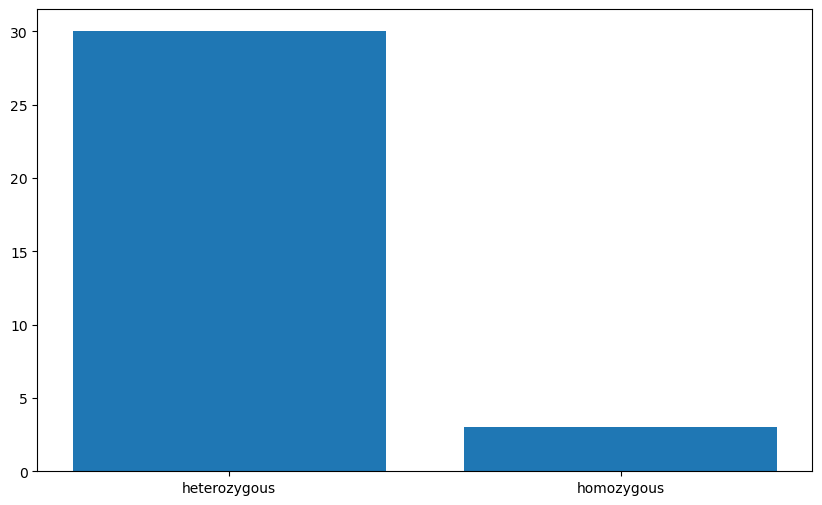

zygosity,count
str,u32
"""heterozygous""",30
"""homozygous""",3


In [89]:
# Descriptive Statistics
# 1. How is the split of zygosity?
grouped_by_zygosity = df.groupby('zygosity').count()
num_zygosity = grouped_by_zygosity.height

barchart(grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], figsize=figsize)

grouped_by_zygosity.head()

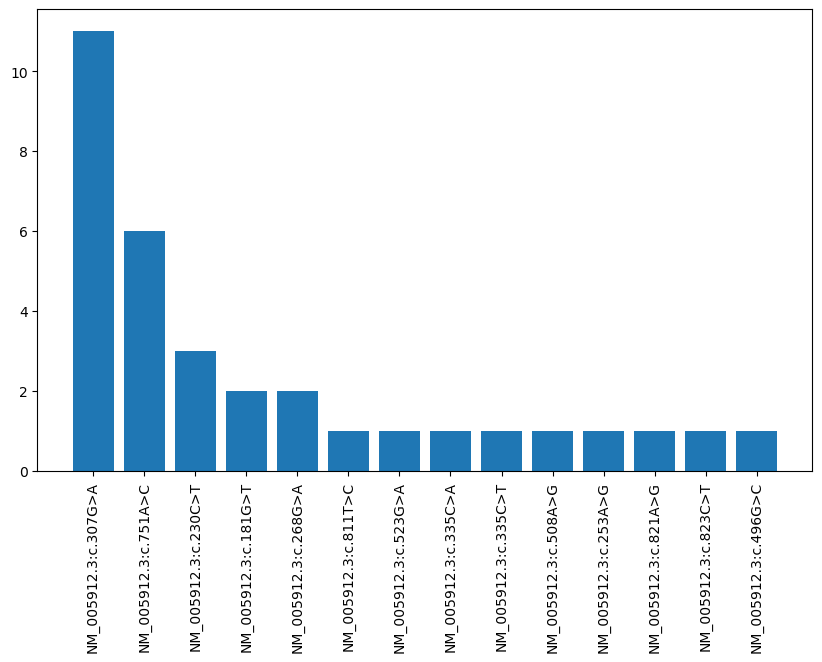

c_hgvs,count
str,u32
"""NM_005912.3:c.…",11
"""NM_005912.3:c.…",6
"""NM_005912.3:c.…",3
"""NM_005912.3:c.…",2
"""NM_005912.3:c.…",2
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1


In [90]:
# 2. Distribution of c_hgvs mutations?
grouped_by_c_hgvs = df.groupby('c_hgvs').count().sort('count', descending=True)
num_c_hgvs = grouped_by_c_hgvs.height

barchart(grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], figsize=figsize, x_tick_rotation='vertical')

grouped_by_c_hgvs.head(50)

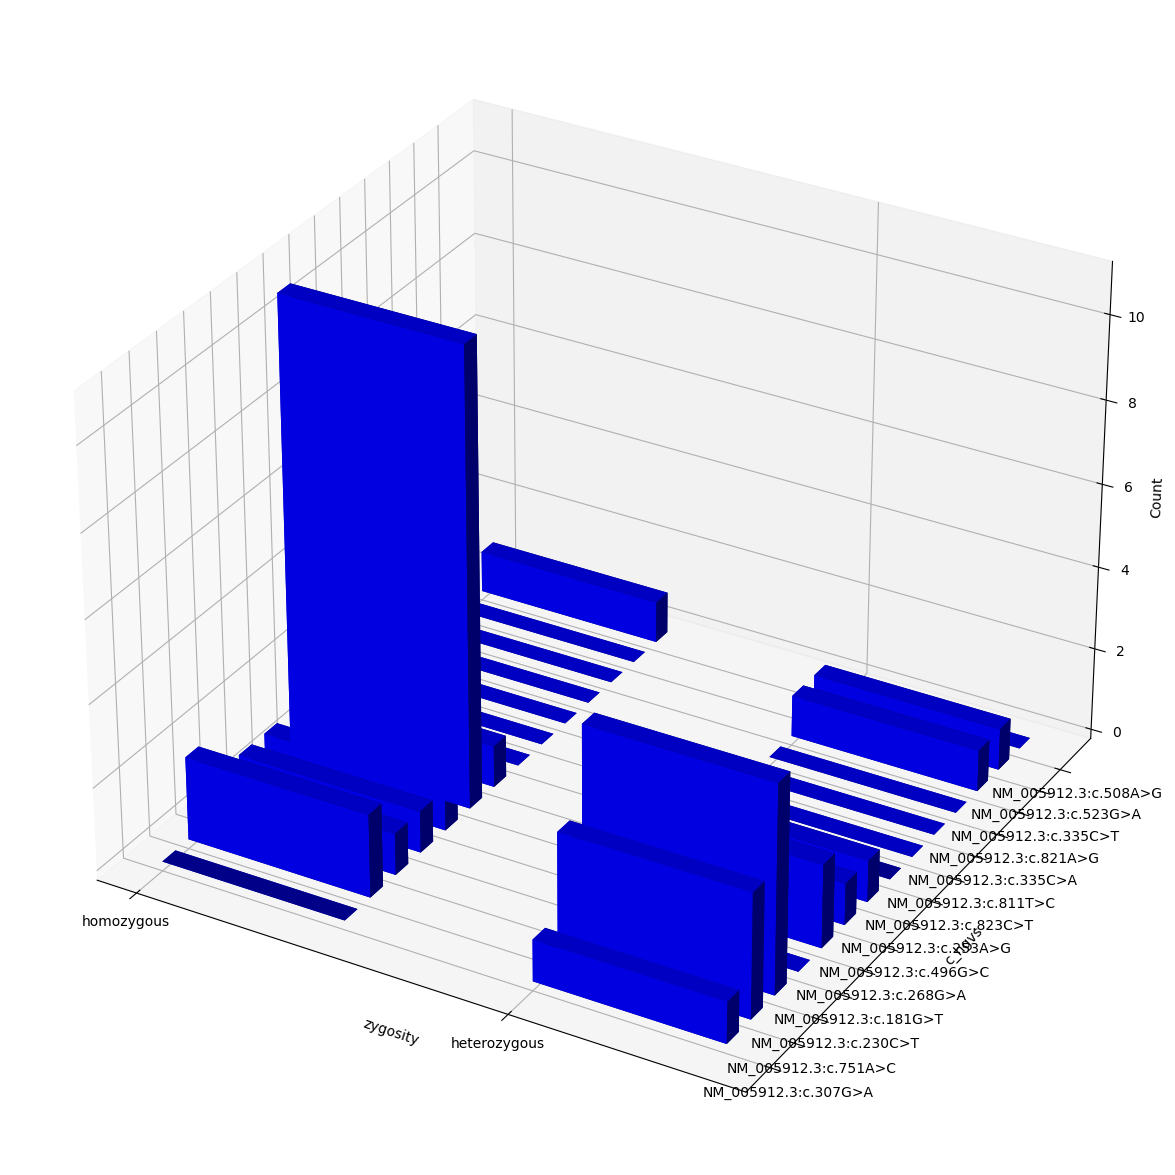

In [52]:
# 3. What if we split the distribution of c_hgvs mutations by zygosity?
from ERKER2Phenopackets.src.utils.polars_utils import barchart_3d
barchart_3d(df, 'zygosity', 'c_hgvs', figsize=figsize, grouped_by_col1=grouped_by_zygosity, grouped_by_col2=grouped_by_c_hgvs)

In [40]:
# 4. Distribution of obesity classes?

In [41]:
# 5. What if we split the distribution of obesity classes by zygosity?

In [42]:
# 6. What if we split the distribution of obesity classes by c_hgvs mutation?

In [43]:
# 7. What if we split the distribution of obesity classes by c_hgvs mutation and zygosity?

In [44]:
# 8. How long does it take for a person to develop the different obesity classes based on their mutation?